## NLP Draft Predictions

This notebook details our initial attempt for the supervised task of predicting NHL player draft positions and the unsupervised task of clustering NHL players based on similarities. The main methodology uses NLP word vectors extracted from 2014-2022 NHL scouting reports from various public sports news outlets.

Members:
- Quoc-Huy Nguyen
- Ryan DeSalvio



In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

data.head()

,Year,Position,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2022,LW,1,MON,1.0,Juraj Slafkovsky,Slafkovsky has all the assets you’re looking f...,Slafkovsky is one of the draft’s most tantaliz...,Slafkovsky can be a menace at the NHL level. H...,The potential of what Slafkovsky can be as he ...,Slafkovský is one of the largest players in th...,Nothing brought out Juraj Slafkovský’s draft y...,Slafkovsky dominated the international scene t...,Juraj Slafkovsky drives offense from the wing....
1,2022,C,4,SEA,2.0,Shane Wright,Wright is a very well-rounded center who has n...,Still my top prospect in this class (though no...,The complicated and essential question to answ...,With high-end hockey sense highlighted by his ...,The top player from the class held this positi...,In a draft year shaped by substantial depth ra...,Wright has been on the radar of scouts for a l...,Shane Wright is an elite two-way center with i...
2,2022,D,2,NJD,4.0,Simon Nemec,Nemec is a very well-rounded defenseman. His p...,This kid turned 18 in the middle of February a...,"With Nemec, you are netting a top pairing defe...","One of the very best passers in this draft, Ne...",The statistical comparables to Nemec's draft y...,Šimon Nemec just put together the most product...,Few players have been as dominant at the pro-l...,Simon Nemec is a mobile two-way and highly-int...
3,2022,C,3,ARI,3.0,Logan Cooley,Cooley is a dynamic player. When he has the pu...,"Cooley is a beautiful, flowing skater capable ...",Logan Cooley is for sure one of the more well-...,"Over the last several months, I have constantl...","A highly creative, speed-driven pivot who brin...",You won’t find a more singularly-gifted puckha...,"A small, speedy center, Cooley dominated the U...",Juraj Slafkovsky drives offense from the wing....
4,2022,D,6,CBJ,5.0,David Jiricek,"Jiricek is a big, right-shot defenseman who ma...",After suffering a knee injury at the world jun...,Top pairing defenseman at the NHL level if he ...,"A highly mobile, 6-foot-3 defenseman with a bo...","A knee injury fractured Jiříček’s season, but ...",David Jiříček finishes the year as the highest...,"Similar to Nemec, Jiricek plays a mature game ...",David Jiricek is an exceptional two-way defens...


In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               318 non-null    int64  
 1   Position                           318 non-null    object 
 2   Drafted                            318 non-null    int64  
 3   Team                               318 non-null    object 
 4   Average Ranking                    96 non-null     float64
 5   Name                               318 non-null    object 
 6   Description - Corey Pronman        310 non-null    object 
 7   Description - Scott Wheeler        141 non-null    object 
 8   Description - Smaht Scouting       90 non-null     object 
 9   Description - ESPN (Chris Peters)  155 non-null    object 
 10  Description - EP Rinkside          144 non-null    object 
 11  Description - EP Rinkside Part 2   138 non-null    object 

## Exploratory Data Analysis

This visualization explores the accuracy/predictiveness of the `Average Ranking` feature in the dataset. **How well does `Average Ranking` predict the actual draft position?** We find that for the highly ranked players, the average ranking statistic seems pretty accurate as it follows well with a close resemblance to a 1-1 correspondence to the actual draft position (as indicated by conformance to the y=x line). However, for lower ranked players, there is more variation in their actual draft prediction (as shown by the spread and deviation from the y=x line).

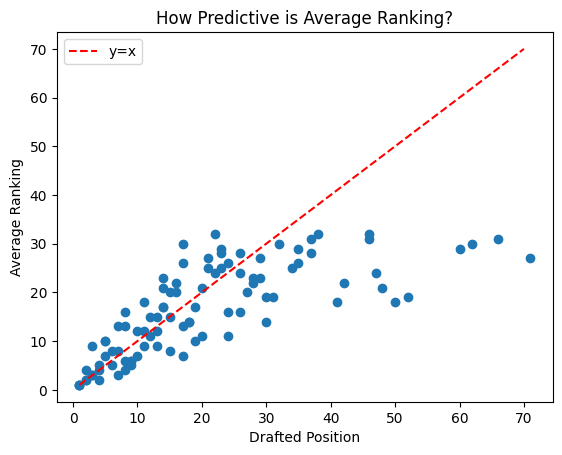

In [4]:
# define the y=x line for perfect alignment where the average
#   player ranking would have predicted the draft position
xx = np.arange(data['Drafted'].min(), data['Drafted'].max())
yy = xx

plt.scatter(data['Drafted'], data['Average Ranking'])
plt.plot(xx, yy, 'r--', label="y=x")
plt.xlabel("Drafted Position")
plt.ylabel("Average Ranking")
plt.legend()
plt.title("How Predictive is Average Ranking?")
plt.show()


From observing the count of non-missing values from the `Dataframe.info()` method, we may ask: **Why are there so many missing values for the `Average Ranking` feature?** After a bit of exploration, we find that scouting reports sourced prior to 2020 did not have this feature. 

In [5]:
mask = data['Average Ranking'].isnull()
for year, value in data[mask].groupby('Year').count().iloc[:,0].reset_index().to_numpy():
    print(f"For scouting reports with a missing value for `Average Ranking`, {value} come from {year}")

for year, value in data[~mask].groupby('Year').count().iloc[:,0].reset_index().to_numpy():
    print(f"For scouting reports with a value for `Average Ranking`, {value} come from {year}")

For scouting reports with a missing value for `Average Ranking`, 40 come from 2014
For scouting reports with a missing value for `Average Ranking`, 40 come from 2015
For scouting reports with a missing value for `Average Ranking`, 40 come from 2016
For scouting reports with a missing value for `Average Ranking`, 40 come from 2017
For scouting reports with a missing value for `Average Ranking`, 31 come from 2018
For scouting reports with a missing value for `Average Ranking`, 31 come from 2019
For scouting reports with a value for `Average Ranking`, 32 come from 2020
For scouting reports with a value for `Average Ranking`, 32 come from 2021
For scouting reports with a value for `Average Ranking`, 32 come from 2022


- Why is the `Average Ranking` feature encoded as a float type instead of an int type?
    - `Average Ranking` seems to be more appropriate as a int type, but we are not fully confident due to not knowing the method of computation for this feature. There is not a significant memory issue either.

In [6]:
data[~data['Average Ranking'].isnull()]['Average Ranking']

0      1.0
1      2.0
2      4.0
3      3.0
4      5.0
      ... 
91    28.0
92    29.0
93    30.0
94    31.0
95    32.0
Name: Average Ranking, Length: 96, dtype: float64

**What is the average scouting report length for each player? for each expert?**

In [45]:
# scouting report columns
scouting_reports = data.columns[6:]

# create a temporary DataFrame that stores the token length of each scouting 
#   report instead of the actual text
token_count_df = data.copy(deep=True)

for report in scouting_reports:
    token_count_df[report] = token_count_df[report].apply(
        lambda x: len(word_tokenize(x)) if isinstance(x,str) else np.nan
    )

In [50]:
# average scouting report for each expert
token_count_df[scouting_reports].mean()


Description - Corey Pronman          181.067742
Description - Scott Wheeler          250.212766
Description - Smaht Scouting         214.733333
Description - ESPN (Chris Peters)    160.296774
Description - EP Rinkside             94.972222
Description - EP Rinkside Part 2     560.210145
Description - The Painted Lines      161.858407
Description - FCHockey               370.469841
dtype: float64

In [46]:
# average scouting report for each player
pd.melt(
    token_count_df, 
    id_vars=['Name'], 
    value_vars=scouting_reports,
    var_name='scouting_report',
    value_name='token_count'
).groupby('Name')['token_count'].mean()

Name
\nMysak made the jump to the OHL at the midway point of the season. After struggling to produce in the Czech Republic against men, I was curious to see what he could do against his peers. Mysak hasn’t disappointed. Mysak is a speedy forward who loves to create offense off the rush. He also has excellent hands and an uncanny ability to throttle his speed to confuse defenders. He is a unique player and is fearless in tight. I see him as a scoring winger at the NHL level.    223.857143
A.J. Greer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   321.000000
Aaron Ekblad       

In [44]:
# TODO: AHA! Cleaning is required: the name at index 84 is of length 472!
data['Name'].apply(len).sort_values()

143      8
295      9
221      9
227      9
50       9
      ... 
265     19
152     20
7       20
180     21
84     472
Name: Name, Length: 318, dtype: int64

**Is there an unequal distribution between player positions? (e.g., a lot more forwards than defenders)**

In [54]:
# global variable that encodes the name of each hockey position
#   could be useful for visualization later on
HOCKEY_POSITIONS = {
    'C' : 'Center',
    'D' : 'Defender',
    'RW' : 'Right Wing',
    'LW' : 'Left Wing',
    'G' : 'Goalie'
}

# distribution of player positions
data['Position'].value_counts()

C     110
D      88
RW     63
LW     47
G      10
Name: Position, dtype: int64

## Data Cleaning

In [6]:
# clean up dataset
# might have to look at dropping seattle in the future but for clustering it 
# should not matter
#data = data[data['Team'] != 'SEA']

# try with only forwards
data = data[
    (data['Position'] == 'C') | 
    (data['Position'] == 'LW') | 
    (data['Position'] == 'RW')
]

# encode position
# TODO: we should keep the positions for when we do clustering
le = preprocessing.LabelEncoder()
le.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: le.transform([x])[0])


data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 0 to 310
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               220 non-null    int64  
 1   Position                           220 non-null    int64  
 2   Drafted                            220 non-null    int64  
 3   Team                               220 non-null    object 
 4   Average Ranking                    72 non-null     float64
 5   Name                               220 non-null    object 
 6   Description - Corey Pronman        217 non-null    object 
 7   Description - Scott Wheeler        102 non-null    object 
 8   Description - Smaht Scouting       68 non-null     object 
 9   Description - ESPN (Chris Peters)  108 non-null    object 
 10  Description - EP Rinkside          102 non-null    object 
 11  Description - EP Rinkside Part 2   98 non-null     object 

In [7]:
corpus, labels, draft_position, player_position, player_name = [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]

# create a list of stopwords for player names
player_names = list(data['Name'])
name_stopwords = []
for name in player_names:
  name_split = name.split(' ')
  for part in name_split:
    name_stopwords.append(part.lower())

# remove references to leagues, teams, and nationalities
hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "saginaw", "kelowna"]

# Initialize Python porter stemmer
ps = PorterStemmer()

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    # keep only alpha characters
    r = re.sub('[^a-zA-Z]', ' ', row[report])
    # lower string everything
    r = r.lower()
    # split on spaces
    r = r.split()
    # remove stopwords and any reference to the name of the player
    # TODO: check whether we should initialize stopwords, so we don't call this fuction every time
    r = [word for word in r if word not in stopwords.words('english') and word not in name_stopwords and word not in hockey_words]

    # stem cleansed string
    r = [ps.stem(word) for word in r]
    # lemmatize cleansed string
    #r = [lemmatizer.lemmatize(word) for word in r]

    # remove hockey specific stop words
    #r = [word for word in r if word not in hockey_words]

    # join back on spaces
    r = ' '.join(r)
    text = text + " " + r
  # append to dataset
  corpus.append(text)
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])

# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 220
length of labels: 220
length of draft_position: 220
length of player_position: 220
corpus first 5: [' asset look top foot beat oppon skill possess outstand puck skill put puck leg stick high rate use finess power quick get around defend set finish play well physic run guy compet good enough project top line potenti pop becom true star one draft tantal prospect skill size combo scout coach clamour alreadi demonstr pro competit domest notabl intern big year nine point five game histor silver medal slovak hlinka gretzki cup olymp bronz medal tournament mvp liiga silver medal club team tp team lead nine point men world built like power pound frame make one draft heaviest player play game uncharacterist finess regularli flash expect smaller one one pull puck tight feet got rangi fluid stride make surprisingli danger rush impress confid puck stick enabl hang onto sometim fault attack wall slot take puck half wall home plate area shoot forehand team draft bet upsid grade

In [8]:
X = pd.DataFrame(list(zip(player_name, draft_position, player_position, corpus)), columns=['player_name', 'draft_position', 'player_position', 'report'])
Y = labels

# create train test splits of data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

# vectorize train data
vectorizer = TfidfVectorizer(analyzer='word', min_df=0.03, ngram_range=(2, 3))
X_train_vect = vectorizer.fit_transform(X_train['report'])
print(f"shape of X_train_vect: {X_train_vect.shape}")

# show the most important words
most_important = pd.DataFrame(X_train_vect[0].T.todense(),
    	index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
most_important = most_important.sort_values('TF-IDF', ascending=False)
most_important.head(30)

shape of X_train_vect: (147, 1587)


,TF-IDF
power play,0.236644
one timer,0.227607
one draft,0.194194
got good,0.152812
power skater,0.152812
top pick,0.143333
north america,0.143333
next season,0.141487
well round,0.133505
even strength,0.124065


In [9]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(4, 4)

In [10]:
# this is flawed and from some previous work I was doing but I wanted to keep
# around since it is a good example of setting up a pipeline in sklearn
# so it could be used for a reference
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    return [[row['player_position']] for index, row in x[['draft_position', 'player_position']].iterrows()]

def get_text_data(x):
    return list(x['report'])

transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

# Create a pipeline to concatenate Tfidf Vector and Numeric data
# Use RandomForestClassifier as an example
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word', ngram_range=(1,2)))
            ]))
         ])),
    ('clf', LogisticRegression())
])


# Grid Search Parameters for LogisticRegression
param_grid = {'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear']
              }

# Training config
kfold = StratifiedKFold(n_splits=3)
scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

# Perform GridSearch
rf_model = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_

# best found for now to be 0.16 
# without draft position (I think there is bias with that data)
rf_best.score(X_test, y_test)
"""

"\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.pipeline import Pipeline, FeatureUnion\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.preprocessing import FunctionTransformer\nfrom sklearn.model_selection import GridSearchCV, StratifiedKFold\n\n# Create Function Transformer to use Feature Union\ndef get_numeric_data(x):\n    return [[row['player_position']] for index, row in x[['draft_position', 'player_position']].iterrows()]\n\ndef get_text_data(x):\n    return list(x['report'])\n\ntransfomer_numeric = FunctionTransformer(get_numeric_data)\ntransformer_text = FunctionTransformer(get_text_data)\n\n# Create a pipeline to concatenate Tfidf Vector and Numeric data\n# Use RandomForestClassifier as an example\npipeline = Pipeline([\n    ('features', FeatureUnion([\n            ('numeric_features', Pipeline([\n                ('selector', transfomer_numeric)\n            ])),\n             ('text_features', Pipeline([\n                ('selec

Exploring Kmeans now for unsupervised learning

assigning 10 clusters
assigning 20 clusters
assigning 30 clusters
assigning 40 clusters
assigning 50 clusters
assigning 60 clusters
assigning 70 clusters
assigning 80 clusters
assigning 90 clusters


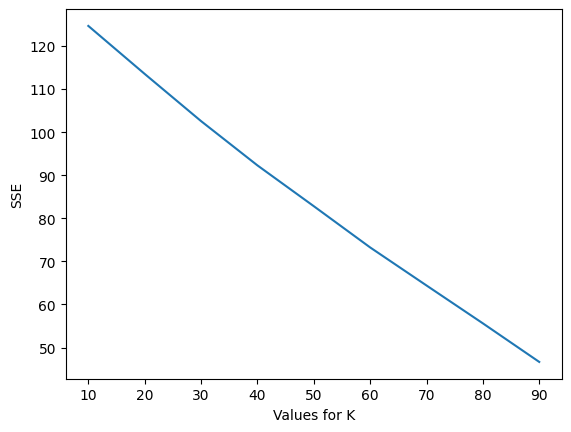

In [11]:
# plot how sse is affected by cluster size choice
# we are looking for a "level off"
def find_cluster_value_using_sse(data, max_k):
  sse={}
  for k in np.arange(10,max_k,10):
      print(f"assigning {k} clusters")
      kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=5).fit(data)
      sse[k] = kmeans.inertia_
  plt.plot(list(sse.keys()),list(sse.values()))
  plt.xlabel('Values for K')
  plt.ylabel('SSE')
  plt.show()
    
find_cluster_value_using_sse(X_train_vect, 100)

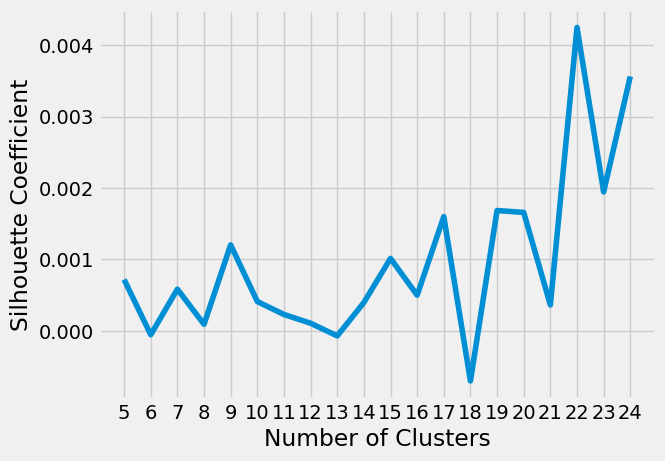

In [12]:
def plot_silhouette_scores(start, end, step):
  # A list holds the silhouette coefficients for each k
  silhouette_coefficients = []

  # Notice you start at 2 clusters for silhouette coefficient
  for k in range(start, end, step):
    kmeans = KMeans(n_clusters=k, n_init=5, max_iter=1000)
    kmeans.fit(X_train_vect)
    score = silhouette_score(X_train_vect, kmeans.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(start, end, step), silhouette_coefficients)
  plt.xticks(range(start, end, step))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

plot_silhouette_scores(5, 25, 1)

The extremely low silhouette score implies there is a lot of overlap in classification of values. There might have to be some more data massaging in order to get this value higher

In [13]:
SELECTED_CLUSTERS = 22

In [14]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=SELECTED_CLUSTERS, n_init = 5)
labels = kmeans.fit_predict(X_train_vect)

X_train['label'] = labels

In [15]:
# show the top words for each cluster that was created
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X_train_vect, X_train.label, vectorizer.get_feature_names_out(), 15)


Cluster 0.0
shot strong,goal scorer,area need,good vision,move puck,offens zone,get move,keep puck,make hard,leg strength,shot draft,strong puck,front net,puck possess,long reach

Cluster 1.0
round pick,capabl play,puck good,power play,net front,break play,offens zone,season play,show patienc,foot frame,top six,year old,high end,two year,next level

Cluster 2.0
get puck,puck offens,quick releas,puck carrier,play high,protect puck,good power,puck quickli,puck offens zone,stick puck,play wing,get puck net,show good,penalti kill,offens zone

Cluster 3.0
big man,along board,use frame,concern game,end skill,high end skill,player class,game look,due size,take game,top end,puck shot,end vision,high end,skill often

Cluster 4.0
get back defens,world junior,point per game,point per,two season,defens play,think game,compet level,offens zone,make good,get shot,past year,puck time,go get,good quick

Cluster 5.0
puck stick,first round,effort level,puck skill,neutral zone,per game,draft class,play 

In [16]:
import plotly.express as px

print(X_train.columns)
print(X_train.head())

#visualize mappings via treemap
result_summary = pd.pivot_table(X_train, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
result_treemap = result_summary
fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count')
fig.show()

Index(['player_name', 'draft_position', 'player_position', 'report', 'label'], dtype='object')
             player_name  draft_position  player_position  \
15   Ivan Miroshnichenko              20                1   
166          Jack Eichel               2                0   
142   Alexander Nylander               8                1   
194          Sam Bennett               4                0   
192         Sam Reinhart               2                0   

                                                report  label  
15    attribut want top got good size strength stro...      5  
166   one best freshmen modern era simpli fantast s...      3  
142   brother leaf prospect son former nhler one to...     18  
194   hard find specif part game weak simpli fantas...      9  
192   dynam hand best pure passer draft class dicta...     10  


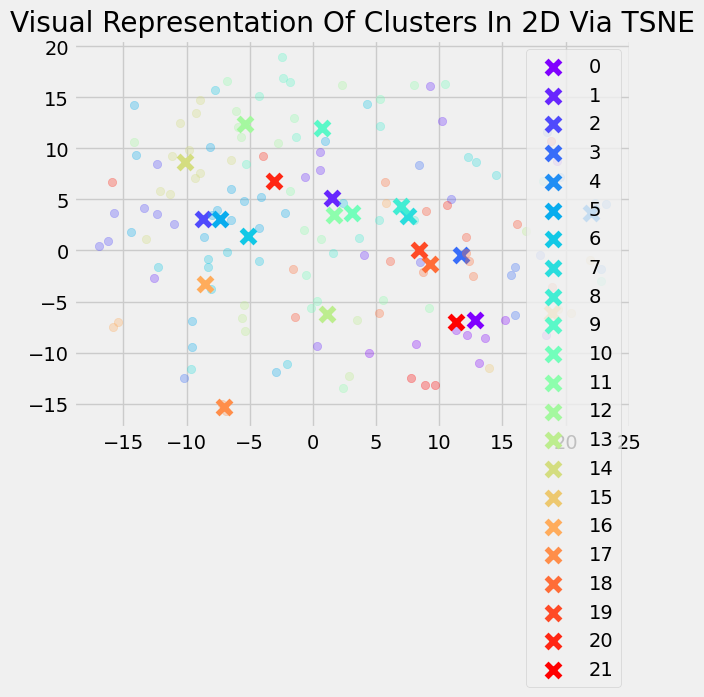

In [17]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(X_train_vect)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

color = cm.rainbow(np.linspace(0, 1, len(X_train.label.unique())))
for category, color in enumerate(color):
    xs = np.array(x)[X_train.label == category]
    ys = np.array(y)[X_train.label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=category)
plt.title("Visual Representation Of Clusters In 2D Via TSNE")
plt.legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb1e772a-d117-46c3-855b-cc1a20b1d888' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>